# Basic Neural Network

A simple feedforward neural network to classify spin configurations. Based off of course material from CSCI 1051 by Teal Witter.

In [3]:
# We start by importing the libraries we'll use today
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

Load the data generated by the ON_Model

In [4]:
# data transforms
dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])


# Use the image folder function to create datasets
dsets = {x: datasets.ImageFolder(f"../data/binary_class/{x}", dset_transform)
         for x in ['train', 'test']}

# dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=16,
#                                               shuffle=(x == "train"))
#                for x in ['train', 'test']}

trainingdata = dsets['train']
testdata = dsets['test']

#load a dataset to test for performance vs temperature
perfdata = datasets.ImageFolder(f"../data/temp_class/test", dset_transform)


trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)
perfDataLoader = torch.utils.data.DataLoader(perfdata,batch_size=64,shuffle=False)

In [5]:
print(len(trainingdata))

820


torch.Size([1, 25, 25])
0


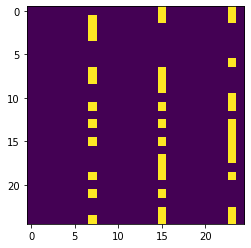

In [12]:
image, label = trainingdata[355]
print(image.shape)
print(label)
plt.imshow(image.squeeze().numpy())
plt.show()

This is a basic feedforward neural net architecture

In [7]:
class NeuralNet(torch.nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(25*25, 256),
      torch.nn.ReLU(),
      torch.nn.Linear(256, 128),
      torch.nn.ReLU(),
      torch.nn.Linear(128, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 2)
    )
  
  def forward(self, x):
    x = x.view(-1, 25*25) # change so 784 vector instead of 28x28 matrix
    return self.layers(x)



In [8]:
# define loss function, optimizer
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

Now let's train our model!

In [13]:
train_loss_history = []
test_loss_history = []

for epoch in range(70):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    optimizer.zero_grad()
    predicted_output = model(images)
    fit = criterion(predicted_output, labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item() / len(trainingdata)
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      predicted_output = model(images)
      fit = criterion(predicted_output, labels)
      test_loss += fit.item() / len(testdata)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')
    

Epoch 0, Train loss 0.00965149991395997, Test loss 0.011122828722000122
Epoch 1, Train loss 0.00964751701529433, Test loss 0.01111759419848279
Epoch 2, Train loss 0.00963271660048787, Test loss 0.011107115047733958
Epoch 3, Train loss 0.00962475316553581, Test loss 0.01109834611415863
Epoch 4, Train loss 0.009605561451214115, Test loss 0.011088497391561182
Epoch 5, Train loss 0.009607713542333465, Test loss 0.011080114797848028
Epoch 6, Train loss 0.009608909487724304, Test loss 0.01107241293279136
Epoch 7, Train loss 0.00959675043094449, Test loss 0.011062863323746659
Epoch 8, Train loss 0.00957812339794345, Test loss 0.011053570596183218
Epoch 9, Train loss 0.009558387863926772, Test loss 0.011044256062042422
Epoch 10, Train loss 0.00954912748278641, Test loss 0.011032686582425746
Epoch 11, Train loss 0.009555444194049372, Test loss 0.01102193550365727
Epoch 12, Train loss 0.009542266261286852, Test loss 0.011009731743393876
Epoch 13, Train loss 0.009528699371872878, Test loss 0.0109

Let's plot our loss by epoch to see how we did.

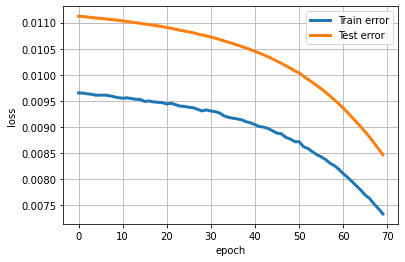

In [15]:
plt.plot(range(70),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(70),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_1816669/469716450.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()


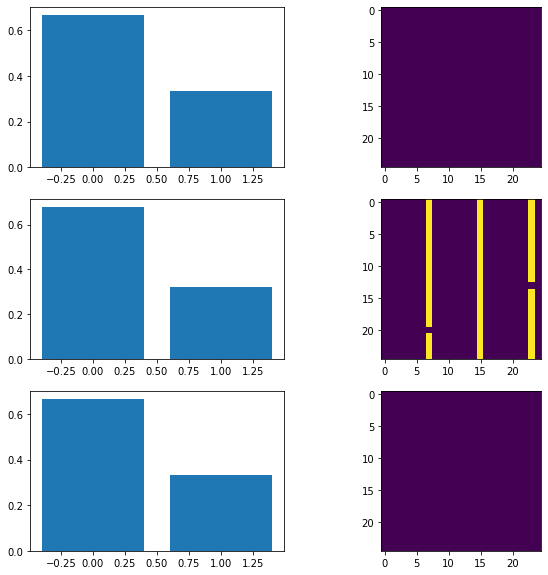

In [11]:
plt.figure(figsize=(10,10))
for index in [0,1,2]:
  
  image = images[index]
  predicted_output = model(images)[index]
  # Need to apply softmax to get probabilities
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()

  plt.subplot(3,2,2*index+1)
  plt.bar(list(range(len(prob_output))), prob_output)
 
  plt.subplot(3,2,2*index+2)
  plt.imshow(image.squeeze().numpy())
  
plt.show()

Now lets use the dataset that we classified by temperature to plot confidence vs temperature

In [ ]:
for idx in range(len(perfdata)):
  image, label = perfdata[idx]
  predicted_output = model(image.unsqueeze(0))
  # Need to apply softmax to get probabilities
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()
  print(f"Image {idx} is a {perfdata.classes[label]} with probability {prob_output[0][1]}")